<a href="https://colab.research.google.com/github/AliKhyar/Data-Science-on-UFC-dataset/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!ls

10fighters.png	       height_reach.png		 sample_data
age.png		       preprocessed_data.csv	 ufcdata.zip
data.csv	       raw_fighter_details.csv	 winby.png
height_difference.png  raw_total_fight_data.csv  winners_age.png


In [0]:
#!unzip ufcdata.zip

##Libraries

In [0]:
#!pip3 install catboost

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.graph_objs as go
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier

##Functions

In [0]:
# convert foot + inch to cm
def to_cm(X):
  if X == np.NaN:
    return X
  elif len(str(X).split("'")) == 2:
    foots = float(str(X).split("'")[0].strip())
    inchs = float(str(X).split("'")[1].replace('"', '').strip())
    return foots*30.48 + inchs*2.54
  else:
    return float(str(X).split('"')[0].strip())*30.84

# convert lbs to cm
def to_kg(X):
  if X == np.NaN:
    return X
  else:
    lbs = float(str(X).replace("lbs.", "").strip())
    return lbs*0.45359237


#extract fight type
def fight_type(X):
  weight_classes = ['Women\'s Strawweight', 'Women\'s Bantamweight', 
                  'Women\'s Featherweight', 'Women\'s Flyweight', 'Lightweight', 
                  'Welterweight', 'Middleweight','Light Heavyweight', 
                  'Heavyweight', 'Featherweight','Bantamweight', 'Flyweight', 'Open Weight']
  for Division in weight_classes:
      if Division in X:
        return Division
  if X == 'Catch Weight Bout' or 'Catchweight Bout':
    return 'Catch Weight'
  else:
    return 'Open Weight'

#determine age
def get_age(row):
    B_age = (row['date_year'] - row['B_year'])
    R_age = (row['date_year'] - row['R_year'])
    if np.isnan(B_age)!=True:
        B_age = B_age
    if np.isnan(R_age)!=True:
        R_age = R_age
    return pd.Series([B_age, R_age], index=['B_age', 'R_age'])

#determine number of rounds
def get_rounds(X):
    if X == 'No Time Limit':
        return 1
    else:
        return len(X.split('(')[1].replace(')', '').split('-'))

#change winer name to B or R, if NaN => Draw
def get_renamed_winner(row):
    if row['R_fighter'] == row['Winner']:
        return 'Red'
    elif row['B_fighter'] == row['Winner']:
        return 'Blue'
    elif row['Winner'] == 'Draw':
        return 'Draw'

In [0]:
fighter_details = pd.read_csv('raw_fighter_details.csv')
fights_data = pd.read_csv('raw_total_fight_data.csv', sep=';')

In [71]:
fighter_details.head()

,fighter_name,Height,Weight,Reach,Stance,DOB
0,AJ Fonseca,"5' 4""",145 lbs.,NaN,NaN,NaN
1,AJ Matthews,"5' 11""",185 lbs.,NaN,NaN,NaN
2,AJ McKee,"5' 10""",145 lbs.,NaN,NaN,NaN
3,AJ Siscoe,"5' 7""",135 lbs.,NaN,NaN,NaN
4,Aalon Cruz,"6' 0""",145 lbs.,NaN,NaN,NaN


In [72]:
fighter_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 6 columns):
fighter_name    3313 non-null object
Height          3050 non-null object
Weight          3238 non-null object
Reach           1569 non-null object
Stance          2439 non-null object
DOB             2573 non-null object
dtypes: object(6)
memory usage: 155.4+ KB


##preprocess data 
<br>1 foot = 30.48 cm
 <br>1 inch = 2.54 cm

In [0]:
fighter_details['Height'] = fighter_details['Height'].apply(to_cm)
fighter_details['Reach'] = fighter_details['Reach'].apply(to_cm)
fighter_details['Weight'] = fighter_details['Weight'].apply(to_kg)
fighter_details['DOB'] = pd.to_datetime(fighter_details['DOB'])


In [74]:
fighter_details.tail()

,fighter_name,Height,Weight,Reach,Stance,DOB
3308,Zelim Imadaev,182.88,77.110703,2343.84,Orthodox,1995-01-25
3309,Zhang Lipeng,180.34,70.306817,2189.64,Southpaw,1990-03-10
3310,Zoila Frausto,162.56,61.234970,NaN,Orthodox,NaT
3311,Zu Anyanwu,185.42,113.851685,2374.68,Orthodox,1981-08-05
3312,Zubaira Tukhugov,172.72,65.770894,2097.12,Orthodox,1991-01-15


In [75]:
fights_data.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,R_TD,B_TD,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,R_HEAD,B_HEAD,R_BODY,B_BODY,R_LEG,B_LEG,R_DISTANCE,B_DISTANCE,R_CLINCH,B_CLINCH,R_GROUND,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Henry Cejudo,Marlon Moraes,0,0,90 of 171,57 of 119,52%,47%,99 of 182,59 of 121,1 of 4,0 of 2,25%,0%,1,0,1,0,0,0,73 of 150,35 of 89,13 of 16,7 of 8,4 of 5,15 of 22,45 of 118,54 of 116,19 of 23,2 of 2,26 of 30,1 of 1,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),Marc Goddard,"June 08, 2019","Chicago, Illinois, USA",UFC Bantamweight Title Bout,Henry Cejudo
1,Valentina Shevchenko,Jessica Eye,1,0,8 of 11,2 of 12,72%,16%,37 of 40,42 of 52,2 of 2,0 of 0,100%,0%,1,0,3,0,0,0,4 of 5,0 of 7,4 of 6,0 of 2,0 of 0,2 of 3,5 of 8,2 of 12,2 of 2,0 of 0,1 of 1,0 of 0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),Robert Madrigal,"June 08, 2019","Chicago, Illinois, USA",UFC Women's Flyweight Title Bout,Valentina Shevchenko
2,Tony Ferguson,Donald Cerrone,0,0,104 of 200,68 of 185,52%,36%,104 of 200,68 of 185,0 of 0,1 of 1,0%,100%,0,0,0,0,0,0,65 of 144,43 of 152,25 of 37,15 of 23,14 of 19,10 of 10,103 of 198,68 of 184,1 of 2,0 of 1,0 of 0,0 of 0,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Lightweight Bout,Tony Ferguson
3,Jimmie Rivera,Petr Yan,0,2,73 of 192,56 of 189,38%,29%,76 of 195,58 of 192,0 of 3,1 of 3,0%,33%,0,0,0,1,0,0,42 of 145,40 of 166,15 of 24,13 of 19,16 of 23,3 of 4,60 of 173,42 of 167,9 of 15,10 of 12,4 of 4,4 of 10,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Kevin MacDonald,"June 08, 2019","Chicago, Illinois, USA",Bantamweight Bout,Petr Yan
4,Tai Tuivasa,Blagoy Ivanov,0,1,64 of 144,73 of 123,44%,59%,66 of 146,81 of 131,0 of 0,2 of 2,0%,100%,0,0,0,0,0,0,39 of 114,65 of 114,6 of 7,7 of 8,19 of 23,1 of 1,50 of 126,62 of 111,14 of 18,5 of 6,0 of 0,6 of 6,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Heavyweight Bout,Blagoy Ivanov


In [76]:
fights_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 41 columns):
R_fighter          5144 non-null object
B_fighter          5144 non-null object
R_KD               5144 non-null int64
B_KD               5144 non-null int64
R_SIG_STR.         5144 non-null object
B_SIG_STR.         5144 non-null object
R_SIG_STR_pct      5144 non-null object
B_SIG_STR_pct      5144 non-null object
R_TOTAL_STR.       5144 non-null object
B_TOTAL_STR.       5144 non-null object
R_TD               5144 non-null object
B_TD               5144 non-null object
R_TD_pct           5144 non-null object
B_TD_pct           5144 non-null object
R_SUB_ATT          5144 non-null int64
B_SUB_ATT          5144 non-null int64
R_PASS             5144 non-null int64
B_PASS             5144 non-null int64
R_REV              5144 non-null int64
B_REV              5144 non-null int64
R_HEAD             5144 non-null object
B_HEAD             5144 non-null object
R_BODY             51

In [77]:
fights_data['Fight_type'].value_counts()

Lightweight Bout                                                 947
Welterweight Bout                                                915
Middleweight Bout                                                684
Light Heavyweight Bout                                           453
Heavyweight Bout                                                 453
                                                                ... 
UFC 12 Heavyweight Tournament Title Bout                           1
Ultimate Fighter 23 Women's Strawweight Tournament Title Bout      1
Ultimate Fighter China Welterweight Tournament Title Bout          1
UFC 1 Tournament Title Bout                                        1
Ultimate Fighter Brazil 2 Welterweight Tournament Title Bout       1
Name: Fight_type, Length: 112, dtype: int64

In [78]:
fights_data.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR.', 'B_SIG_STR.',
       'R_SIG_STR_pct', 'B_SIG_STR_pct', 'R_TOTAL_STR.', 'B_TOTAL_STR.',
       'R_TD', 'B_TD', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',
       'R_PASS', 'B_PASS', 'R_REV', 'B_REV', 'R_HEAD', 'B_HEAD', 'R_BODY',
       'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH',
       'B_CLINCH', 'R_GROUND', 'B_GROUND', 'win_by', 'last_round',
       'last_round_time', 'Format', 'Referee', 'date', 'location',
       'Fight_type', 'Winner'],
      dtype='object')>

In [79]:
# split attempted strikes and landed strikes
cols = ['R_SIG_STR.', 'B_SIG_STR.', 'R_TOTAL_STR.', 'B_TOTAL_STR.',
       'R_TD', 'B_TD', 'R_HEAD', 'B_HEAD', 'R_BODY','B_BODY', 'R_LEG', 'B_LEG', 
        'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH','B_CLINCH', 'R_GROUND', 'B_GROUND']

attemp = '_attempted'
landed = '_landed'

for col in cols:
    fights_data[col+attemp] = fights_data[col].apply(lambda X: int(X.split('of')[1]))
    fights_data[col+landed] = fights_data[col].apply(lambda X: int(X.split('of')[0]))
    
fights_data.drop(cols, axis=1, inplace=True)
fights_data.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner,R_SIG_STR._attempted,R_SIG_STR._landed,B_SIG_STR._attempted,B_SIG_STR._landed,R_TOTAL_STR._attempted,R_TOTAL_STR._landed,B_TOTAL_STR._attempted,B_TOTAL_STR._landed,R_TD_attempted,R_TD_landed,B_TD_attempted,B_TD_landed,R_HEAD_attempted,R_HEAD_landed,B_HEAD_attempted,B_HEAD_landed,R_BODY_attempted,R_BODY_landed,B_BODY_attempted,B_BODY_landed,R_LEG_attempted,R_LEG_landed,B_LEG_attempted,B_LEG_landed,R_DISTANCE_attempted,R_DISTANCE_landed,B_DISTANCE_attempted,B_DISTANCE_landed,R_CLINCH_attempted,R_CLINCH_landed,B_CLINCH_attempted,B_CLINCH_landed,R_GROUND_attempted,R_GROUND_landed,B_GROUND_attempted,B_GROUND_landed
0,Henry Cejudo,Marlon Moraes,0,0,52%,47%,25%,0%,1,0,1,0,0,0,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),Marc Goddard,"June 08, 2019","Chicago, Illinois, USA",UFC Bantamweight Title Bout,Henry Cejudo,171,90,119,57,182,99,121,59,4,1,2,0,150,73,89,35,16,13,8,7,5,4,22,15,118,45,116,54,23,19,2,2,30,26,1,1
1,Valentina Shevchenko,Jessica Eye,1,0,72%,16%,100%,0%,1,0,3,0,0,0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),Robert Madrigal,"June 08, 2019","Chicago, Illinois, USA",UFC Women's Flyweight Title Bout,Valentina Shevchenko,11,8,12,2,40,37,52,42,2,2,0,0,5,4,7,0,6,4,2,0,0,0,3,2,8,5,12,2,2,2,0,0,1,1,0,0
2,Tony Ferguson,Donald Cerrone,0,0,52%,36%,0%,100%,0,0,0,0,0,0,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Lightweight Bout,Tony Ferguson,200,104,185,68,200,104,185,68,0,0,1,1,144,65,152,43,37,25,23,15,19,14,10,10,198,103,184,68,2,1,1,0,0,0,0,0
3,Jimmie Rivera,Petr Yan,0,2,38%,29%,0%,33%,0,0,0,1,0,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Kevin MacDonald,"June 08, 2019","Chicago, Illinois, USA",Bantamweight Bout,Petr Yan,192,73,189,56,195,76,192,58,3,0,3,1,145,42,166,40,24,15,19,13,23,16,4,3,173,60,167,42,15,9,12,10,4,4,10,4
4,Tai Tuivasa,Blagoy Ivanov,0,1,44%,59%,0%,100%,0,0,0,0,0,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Heavyweight Bout,Blagoy Ivanov,144,64,123,73,146,66,131,81,0,0,2,2,114,39,114,65,7,6,8,7,23,19,1,1,126,50,111,62,18,14,6,5,0,0,6,6


In [80]:
fights_data.tail()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner,R_SIG_STR._attempted,R_SIG_STR._landed,B_SIG_STR._attempted,B_SIG_STR._landed,R_TOTAL_STR._attempted,R_TOTAL_STR._landed,B_TOTAL_STR._attempted,B_TOTAL_STR._landed,R_TD_attempted,R_TD_landed,B_TD_attempted,B_TD_landed,R_HEAD_attempted,R_HEAD_landed,B_HEAD_attempted,B_HEAD_landed,R_BODY_attempted,R_BODY_landed,B_BODY_attempted,B_BODY_landed,R_LEG_attempted,R_LEG_landed,B_LEG_attempted,B_LEG_landed,R_DISTANCE_attempted,R_DISTANCE_landed,B_DISTANCE_attempted,B_DISTANCE_landed,R_CLINCH_attempted,R_CLINCH_landed,B_CLINCH_attempted,B_CLINCH_landed,R_GROUND_attempted,R_GROUND_landed,B_GROUND_attempted,B_GROUND_landed
5139,Gerard Gordeau,Kevin Rosier,1,0,64%,0%,0%,0%,0,0,0,0,0,0,KO/TKO,1,0:59,No Time Limit,Joao Alberto Barreto,"November 12, 1993","Denver, Colorado, USA",Open Weight Bout,Gerard Gordeau,17,11,3,0,17,11,3,0,0,0,0,0,13,7,1,0,1,1,1,0,3,3,1,0,8,5,3,0,0,0,0,0,9,6,0,0
5140,Ken Shamrock,Patrick Smith,0,0,100%,50%,50%,0%,2,0,0,0,0,0,Submission,1,1:49,No Time Limit,Joao Alberto Barreto,"November 12, 1993","Denver, Colorado, USA",Open Weight Bout,Ken Shamrock,1,1,8,4,4,4,20,16,2,1,0,0,1,1,4,1,0,0,1,1,0,0,3,2,0,0,1,1,0,0,1,1,1,1,6,2
5141,Royce Gracie,Art Jimmerson,0,0,0%,0%,100%,0%,0,0,2,0,0,0,Submission,1,2:18,No Time Limit,Joao Alberto Barreto,"November 12, 1993","Denver, Colorado, USA",Open Weight Bout,Royce Gracie,3,0,0,0,7,4,0,0,1,1,0,0,1,0,0,0,0,0,0,0,2,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
5142,Kevin Rosier,Zane Frazier,2,0,55%,42%,0%,0%,0,0,0,0,0,0,KO/TKO,1,4:20,No Time Limit,Joao Alberto Barreto,"November 12, 1993","Denver, Colorado, USA",Open Weight Bout,Kevin Rosier,27,15,28,12,53,38,29,13,0,0,0,0,23,12,19,7,4,3,6,3,0,0,3,2,10,4,7,0,9,4,19,10,8,7,2,2
5143,Gerard Gordeau,Teila Tuli,0,0,60%,0%,0%,0%,0,0,0,0,0,0,KO/TKO,1,0:26,No Time Limit,Joao Alberto Barreto,"November 12, 1993","Denver, Colorado, USA",Open Weight Bout,Gerard Gordeau,5,3,1,0,5,3,1,0,0,0,1,0,5,3,1,0,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,0,2,2,0,0


In [81]:
# percentages to fractions

cols = ['R_SIG_STR_pct','B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct']

for col in cols:
    fights_data[col] = fights_data[col].apply(lambda X: float(X.replace('%', ''))/100)

fights_data.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner,R_SIG_STR._attempted,R_SIG_STR._landed,B_SIG_STR._attempted,B_SIG_STR._landed,R_TOTAL_STR._attempted,R_TOTAL_STR._landed,B_TOTAL_STR._attempted,B_TOTAL_STR._landed,R_TD_attempted,R_TD_landed,B_TD_attempted,B_TD_landed,R_HEAD_attempted,R_HEAD_landed,B_HEAD_attempted,B_HEAD_landed,R_BODY_attempted,R_BODY_landed,B_BODY_attempted,B_BODY_landed,R_LEG_attempted,R_LEG_landed,B_LEG_attempted,B_LEG_landed,R_DISTANCE_attempted,R_DISTANCE_landed,B_DISTANCE_attempted,B_DISTANCE_landed,R_CLINCH_attempted,R_CLINCH_landed,B_CLINCH_attempted,B_CLINCH_landed,R_GROUND_attempted,R_GROUND_landed,B_GROUND_attempted,B_GROUND_landed
0,Henry Cejudo,Marlon Moraes,0,0,0.52,0.47,0.25,0.00,1,0,1,0,0,0,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),Marc Goddard,"June 08, 2019","Chicago, Illinois, USA",UFC Bantamweight Title Bout,Henry Cejudo,171,90,119,57,182,99,121,59,4,1,2,0,150,73,89,35,16,13,8,7,5,4,22,15,118,45,116,54,23,19,2,2,30,26,1,1
1,Valentina Shevchenko,Jessica Eye,1,0,0.72,0.16,1.00,0.00,1,0,3,0,0,0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),Robert Madrigal,"June 08, 2019","Chicago, Illinois, USA",UFC Women's Flyweight Title Bout,Valentina Shevchenko,11,8,12,2,40,37,52,42,2,2,0,0,5,4,7,0,6,4,2,0,0,0,3,2,8,5,12,2,2,2,0,0,1,1,0,0
2,Tony Ferguson,Donald Cerrone,0,0,0.52,0.36,0.00,1.00,0,0,0,0,0,0,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Lightweight Bout,Tony Ferguson,200,104,185,68,200,104,185,68,0,0,1,1,144,65,152,43,37,25,23,15,19,14,10,10,198,103,184,68,2,1,1,0,0,0,0,0
3,Jimmie Rivera,Petr Yan,0,2,0.38,0.29,0.00,0.33,0,0,0,1,0,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Kevin MacDonald,"June 08, 2019","Chicago, Illinois, USA",Bantamweight Bout,Petr Yan,192,73,189,56,195,76,192,58,3,0,3,1,145,42,166,40,24,15,19,13,23,16,4,3,173,60,167,42,15,9,12,10,4,4,10,4
4,Tai Tuivasa,Blagoy Ivanov,0,1,0.44,0.59,0.00,1.00,0,0,0,0,0,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Heavyweight Bout,Blagoy Ivanov,144,64,123,73,146,66,131,81,0,0,2,2,114,39,114,65,7,6,8,7,23,19,1,1,126,50,111,62,18,14,6,5,0,0,6,6


In [82]:
fights_data['Fight_type'].value_counts()


Lightweight Bout                                                 947
Welterweight Bout                                                915
Middleweight Bout                                                684
Light Heavyweight Bout                                           453
Heavyweight Bout                                                 453
                                                                ... 
UFC 12 Heavyweight Tournament Title Bout                           1
Ultimate Fighter 23 Women's Strawweight Tournament Title Bout      1
Ultimate Fighter China Welterweight Tournament Title Bout          1
UFC 1 Tournament Title Bout                                        1
Ultimate Fighter Brazil 2 Welterweight Tournament Title Bout       1
Name: Fight_type, Length: 112, dtype: int64

In [83]:
fights_data['Fight_type'] = fights_data['Fight_type'].apply(fight_type)
fights_data['Fight_type'].value_counts()

Lightweight              989
Welterweight             969
Middleweight             725
Heavyweight              507
Light Heavyweight        502
Featherweight            442
Bantamweight             379
Flyweight                187
Women's Strawweight      143
Women's Bantamweight     111
Open Weight               92
Women's Flyweight         50
Catch Weight              38
Women's Featherweight     10
Name: Fight_type, dtype: int64

In [84]:
fights_data['nb_of_rounds'] = fights_data['Format'].apply(get_rounds)
fights_data['nb_of_rounds'].value_counts()

3    4523
5     423
2      98
1      78
4      22
Name: nb_of_rounds, dtype: int64

In [85]:
fights_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 60 columns):
R_fighter                 5144 non-null object
B_fighter                 5144 non-null object
R_KD                      5144 non-null int64
B_KD                      5144 non-null int64
R_SIG_STR_pct             5144 non-null float64
B_SIG_STR_pct             5144 non-null float64
R_TD_pct                  5144 non-null float64
B_TD_pct                  5144 non-null float64
R_SUB_ATT                 5144 non-null int64
B_SUB_ATT                 5144 non-null int64
R_PASS                    5144 non-null int64
B_PASS                    5144 non-null int64
R_REV                     5144 non-null int64
B_REV                     5144 non-null int64
win_by                    5144 non-null object
last_round                5144 non-null int64
last_round_time           5144 non-null object
Format                    5144 non-null object
Referee                   5121 non-null object
date 

**Referee :                 5121<br>
Winner :                5061**

In [86]:
fights_data['Winner'].isnull().sum() #5144 - 5061

83

In [0]:
fights_data['Winner'].fillna('Draw', inplace=True) #fill the null value with draw

In [88]:
fights_data['Winner'] = fights_data[['R_fighter', 'B_fighter', 'Winner']].apply(get_renamed_winner, axis=1)
fights_data['Winner'].value_counts()

Red     3470
Blue    1591
Draw      83
Name: Winner, dtype: int64

##Merge data

In [0]:
df = fights_data.merge(fighter_details, left_on='R_fighter', right_on='fighter_name', how='left')
df.drop('fighter_name', axis=1, inplace=True)
df.rename(columns={'Height':'R_Height',
                          'Weight':'R_Weight',
                          'Reach':'R_Reach',
                          'Stance':'R_Stance',
                          'DOB':'R_DOB'}, 
                 inplace=True)

In [0]:
df = df.merge(fighter_details, left_on='B_fighter', right_on='fighter_name', how='left')
df.drop('fighter_name', axis=1, inplace=True)
df.rename(columns={'Height':'B_Height',
                          'Weight':'B_Weight',
                          'Reach':'B_Reach',
                          'Stance':'B_Stance',
                          'DOB':'B_DOB'}, 
                 inplace=True)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5144 entries, 0 to 5143
Data columns (total 70 columns):
R_fighter                 5144 non-null object
B_fighter                 5144 non-null object
R_KD                      5144 non-null int64
B_KD                      5144 non-null int64
R_SIG_STR_pct             5144 non-null float64
B_SIG_STR_pct             5144 non-null float64
R_TD_pct                  5144 non-null float64
B_TD_pct                  5144 non-null float64
R_SUB_ATT                 5144 non-null int64
B_SUB_ATT                 5144 non-null int64
R_PASS                    5144 non-null int64
B_PASS                    5144 non-null int64
R_REV                     5144 non-null int64
B_REV                     5144 non-null int64
win_by                    5144 non-null object
last_round                5144 non-null int64
last_round_time           5144 non-null object
Format                    5144 non-null object
Referee                   5121 non-null object
date 

##Age

In [0]:
df['R_DOB'] = pd.to_datetime(df['R_DOB'])
df['B_DOB'] = pd.to_datetime(df['B_DOB'])
df['date'] = pd.to_datetime(df['date'])

In [0]:
df['R_year'] = df['R_DOB'].apply(lambda x: x.year)
df['B_year'] = df['B_DOB'].apply(lambda x: x.year)
df['date_year'] = df['date'].apply(lambda x: x.year)
df[['B_age', 'R_age']]= df[['date_year', 'R_year', 'B_year']].apply(get_age, axis=1)
df.drop(['R_DOB', 'B_DOB','date_year','R_year','B_year'], axis=1, inplace=True)

##location

In [0]:
df['country'] = df['location'].apply(lambda x : x.split(',')[-1])

##Visualization

In [95]:
from plotly.io import write_image
values = df.Winner.value_counts()
labels = values.index
colors = ['red', 'blue', 'green']
trace = go.Pie(labels=labels, 
               values=values,
                marker=dict(colors=colors) 
              )
layout = go.Layout(title='Winner Distribution by Corner Color')
fig = go.Figure(data=trace, layout=layout)
iplot(fig)
# fig.write_image("fig1.jpeg")


In [0]:
df['R_age'] = df['R_age'].fillna(df['R_age'].median())
df['B_age'] = df['B_age'].fillna(df['B_age'].median())

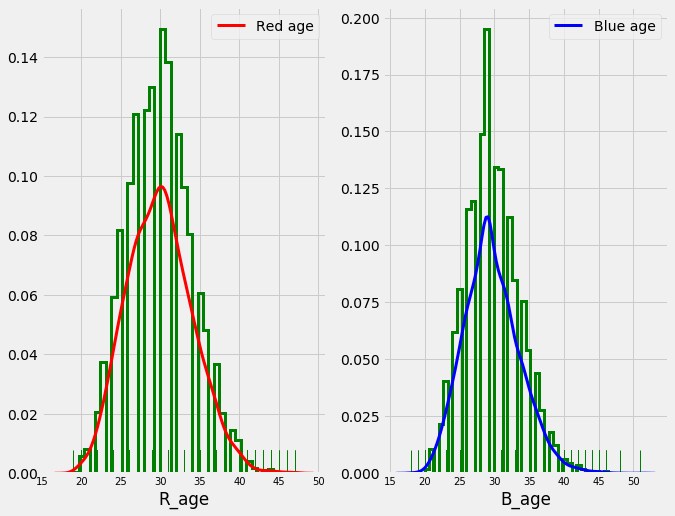

In [97]:
plt.style.use('fivethirtyeight')
f,ax=plt.subplots(1,2,figsize=(10,8))
sns.distplot(df['R_age'], ax=ax[0],rug=True, rug_kws={"color": "g"},
                      kde_kws={"color": "r", "lw": 3, "label": "Red age"},
                      hist_kws={"histtype": "step", "linewidth": 3,
                                "alpha": 1, "color": "g"})

ax[0].set_ylabel('')
hist = sns.distplot(df['B_age'],ax=ax[1],rug=True, rug_kws={"color": "g"},
                      kde_kws={"color": "b", "lw": 3, "label": "Blue age"},
                      hist_kws={"histtype": "step", "linewidth": 3,
                                "alpha": 1, "color": "g"})
plt.savefig('age.png',dpi=300)
plt.show()


In [0]:
# labels = np.array(labels)
# values = np.array(values) 
# clrs = ['grey' if (x < max(values)) else 'green' for x in values ]
# #Configure the size
# plt.figure(figsize=(10,5))
# #barplot
# sns.barplot(x=labels, y=values, palette=clrs) # color=clrs)
# #Rotate x-labels
# # plt.rcParams["ytick.labelsize"] = 1
# plt.xticks(rotation=90)

In [99]:
df_rage = df[['R_fighter','R_age']].copy()
df_rage = df_rage.rename(columns={'R_fighter' : 'fighter', 'R_age' : 'age'})
df_bage = df[['B_fighter', 'B_age']].copy()
df_bage = df_bage.rename(columns={'B_fighter' : 'fighter', 'B_age' : 'age'})
df_aux = df_rage.append(df_bage, sort=False, ignore_index=True)
df_aux.drop_duplicates(subset='fighter', keep='first', inplace=True)

print("oldest fighter: ",df_aux.groupby('age').max().tail(1))
print("youngest fighter: ",df_aux.groupby('age').min().head(1))


oldest fighter:              fighter
age                
51.0  Ron van Clief
youngest fighter:               fighter
age                 
19.0  Sean Daugherty


In [0]:
df['year'] = df['date'].apply(lambda x : int(str(x).split('-')[0]))


In [0]:
values = df['year'].value_counts().sort_values(ascending=False)
clrs = ['b' if (x < max(values)) else 'r' for x in values ]

In [102]:
df_rage = df[['R_fighter','R_age','year']].copy()
df_rage = df_rage.rename(columns={'R_fighter' : 'fighter', 'R_age' : 'age'})
df_bage = df[['B_fighter', 'B_age','year']].copy()
df_bage = df_bage.rename(columns={'B_fighter' : 'fighter', 'B_age' : 'age'})
df_aux = df_rage.append(df_bage, sort=False, ignore_index=True)
df_aux.drop_duplicates(subset='fighter', keep='first', inplace=True)
df_aux = df_aux.groupby('year')['age'].mean()
values = df_aux
labels = values.index
trace = go.Bar(x=labels, y=values)
layout = go.Layout(title='Mean Age distribution by Year (1993-2019)',
                  xaxis = {'title' : 'Year'},
                  yaxis = {'title' : 'Mean Age'})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

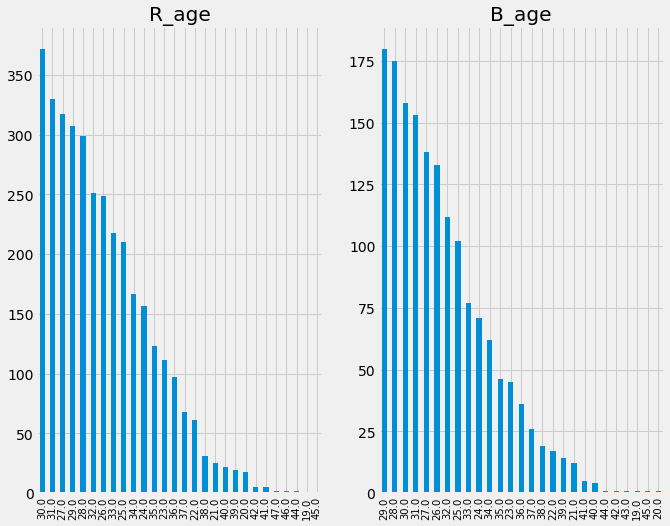

In [103]:
plt.rcParams["xtick.labelsize"] = 10

f,ax=plt.subplots(1,2,figsize=(10,8))
df[df['Winner']=='Red']['R_age'].value_counts().plot.bar(ax=ax[0])

ax[0].set_title('R_age')
ax[0].set_ylabel('')
bar = df[df['Winner']=='Blue']['B_age'].value_counts().plot.bar(ax=ax[1])

ax[1].set_title('B_age')
plt.savefig('winners_age.png', dpi=300)
plt.show()

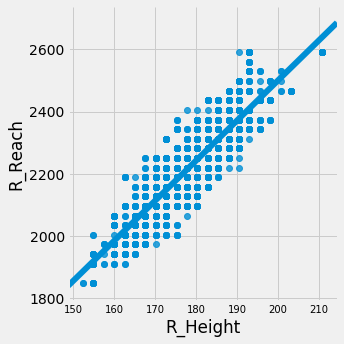

In [104]:
sns.lmplot(x='R_Height', y='R_Reach', data=df)
plt.savefig('height_reach.png', dpi=300)

plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning:

invalid value encountered in less



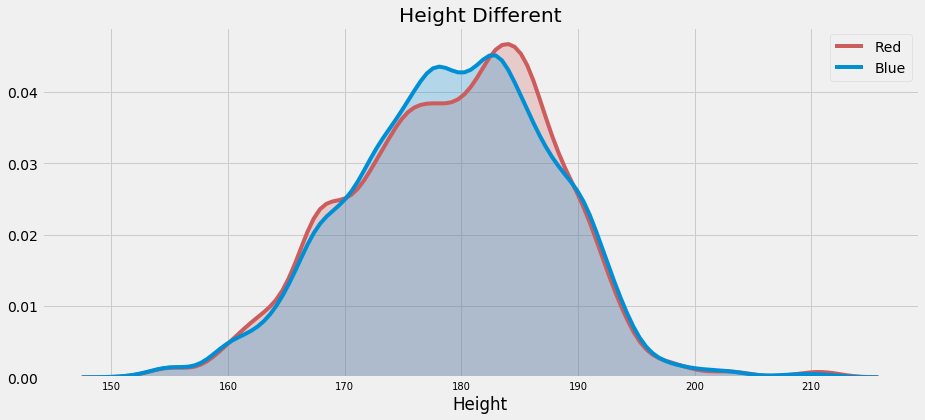

In [105]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(df.R_Height, shade=True, color='indianred', label='Red')
sns.kdeplot(df.B_Height, shade=True, label='Blue')
plt.xlabel('Height')
plt.title('Height Different')
plt.savefig('height_difference.png', dpi=300)
plt.show()

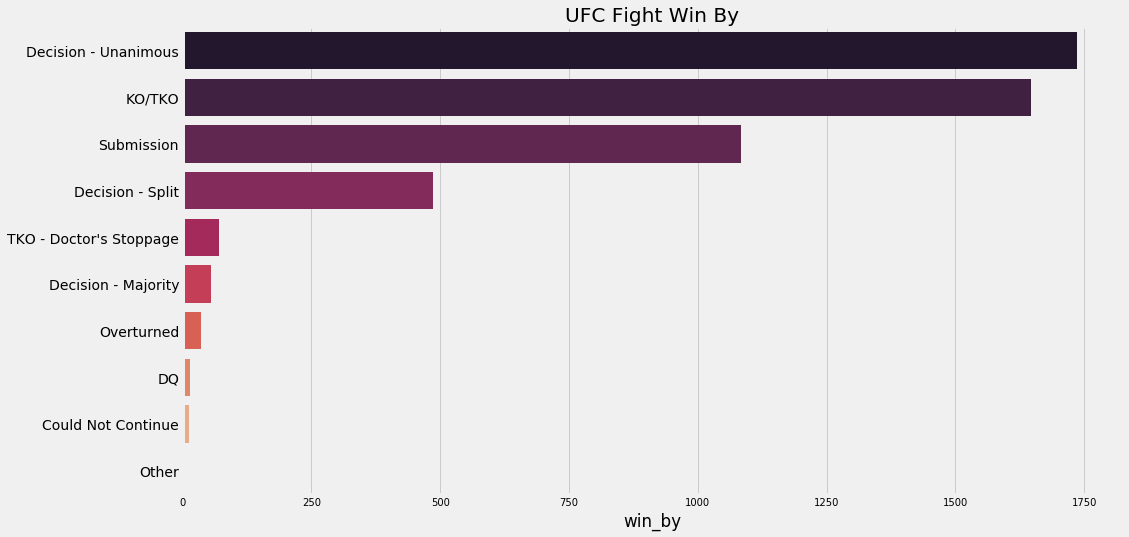

In [106]:
values = df['win_by'].value_counts()
labels = values.index

plt.figure(figsize=(15,8))

sns.barplot(x=values,y=labels, palette='rocket')

plt.title('UFC Fight Win By')
plt.savefig('winby.png', dpi=300)

plt.show()

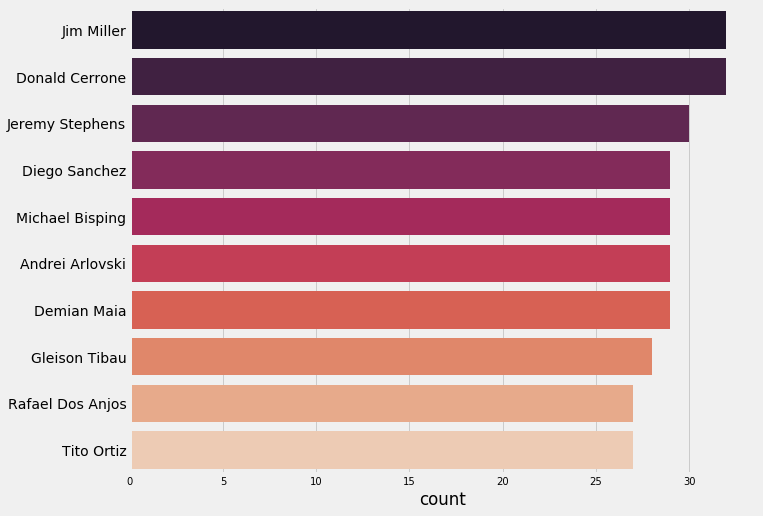

In [107]:
Fighter =  pd.concat([df['R_fighter'], df['B_fighter']], ignore_index=True)
plt.figure(figsize=(10,8))
sns.countplot(y = Fighter, order=pd.value_counts(Fighter).iloc[:10].index,palette='rocket')
plt.savefig('10fighters.png', dpi=300)

plt.show()

In [108]:
df.head(3)

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner,R_SIG_STR._attempted,R_SIG_STR._landed,B_SIG_STR._attempted,B_SIG_STR._landed,R_TOTAL_STR._attempted,R_TOTAL_STR._landed,B_TOTAL_STR._attempted,B_TOTAL_STR._landed,R_TD_attempted,R_TD_landed,B_TD_attempted,B_TD_landed,R_HEAD_attempted,R_HEAD_landed,B_HEAD_attempted,B_HEAD_landed,R_BODY_attempted,R_BODY_landed,B_BODY_attempted,B_BODY_landed,R_LEG_attempted,R_LEG_landed,B_LEG_attempted,B_LEG_landed,R_DISTANCE_attempted,R_DISTANCE_landed,B_DISTANCE_attempted,B_DISTANCE_landed,R_CLINCH_attempted,R_CLINCH_landed,B_CLINCH_attempted,B_CLINCH_landed,R_GROUND_attempted,R_GROUND_landed,B_GROUND_attempted,B_GROUND_landed,nb_of_rounds,R_Height,R_Weight,R_Reach,R_Stance,B_Height,B_Weight,B_Reach,B_Stance,B_age,R_age,country,year
0,Henry Cejudo,Marlon Moraes,0,0,0.52,0.47,0.25,0.0,1,0,1,0,0,0,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Bantamweight,Red,171,90,119,57,182,99,121,59,4,1,2,0,150,73,89,35,16,13,8,7,5,4,22,15,118,45,116,54,23,19,2,2,30,26,1,1,5,162.56,61.234970,1973.76,Orthodox,167.64,61.234970,2066.28,Orthodox,31.0,32.0,USA,2019
1,Valentina Shevchenko,Jessica Eye,1,0,0.72,0.16,1.00,0.0,1,0,3,0,0,0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Women's Flyweight,Red,11,8,12,2,40,37,52,42,2,2,0,0,5,4,7,0,6,4,2,0,0,0,3,2,8,5,12,2,2,2,0,0,1,1,0,0,5,165.10,56.699046,2035.44,Southpaw,167.64,56.699046,2035.44,Orthodox,33.0,31.0,USA,2019
2,Tony Ferguson,Donald Cerrone,0,0,0.52,0.36,0.00,1.0,0,0,0,0,0,0,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Lightweight,Red,200,104,185,68,200,104,185,68,0,0,1,1,144,65,152,43,37,25,23,15,19,14,10,10,198,103,184,68,2,1,1,0,0,0,0,0,3,180.34,70.306817,2343.84,Orthodox,185.42,70.306817,2251.32,Orthodox,36.0,35.0,USA,2019


In [109]:
fighter_details.shape

(3313, 6)

In [110]:
target = df['Winner'].copy()
df.drop(columns=['date','location','Winner','Referee'],inplace=True)
print(f'The dataset have {df.shape[1]} features now.')

The dataset have 68 features now.


In [111]:
df.columns

Index(['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR_pct',
       'B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',
       'R_PASS', 'B_PASS', 'R_REV', 'B_REV', 'win_by', 'last_round',
       'last_round_time', 'Format', 'Fight_type', 'R_SIG_STR._attempted',
       'R_SIG_STR._landed', 'B_SIG_STR._attempted', 'B_SIG_STR._landed',
       'R_TOTAL_STR._attempted', 'R_TOTAL_STR._landed',
       'B_TOTAL_STR._attempted', 'B_TOTAL_STR._landed', 'R_TD_attempted',
       'R_TD_landed', 'B_TD_attempted', 'B_TD_landed', 'R_HEAD_attempted',
       'R_HEAD_landed', 'B_HEAD_attempted', 'B_HEAD_landed',
       'R_BODY_attempted', 'R_BODY_landed', 'B_BODY_attempted',
       'B_BODY_landed', 'R_LEG_attempted', 'R_LEG_landed', 'B_LEG_attempted',
       'B_LEG_landed', 'R_DISTANCE_attempted', 'R_DISTANCE_landed',
       'B_DISTANCE_attempted', 'B_DISTANCE_landed', 'R_CLINCH_attempted',
       'R_CLINCH_landed', 'B_CLINCH_attempted', 'B_CLINCH_landed',
       'R_GROUND_attempted'

In [112]:
df.drop(columns=['Format','country'],inplace=True)
print(f'now it has {df.shape[1]} features.')

now it has 66 features.


In [0]:
# target.reshape(5144,1)

In [114]:
encoder = LabelEncoder()
target = encoder.fit_transform(target)
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.25, random_state=42)
print(f'Input Train Shape {x_train.shape}')
print(f'Output Train Shape {y_train.shape}')
print(f'Input Test Shape {x_test.shape}')
print(f'Output Test Shape {y_test.shape}')

Input Train Shape (3858, 66)
Output Train Shape (3858,)
Input Test Shape (1286, 66)
Output Test Shape (1286,)


In [115]:
num_cols = x_train.columns[x_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))]

x_train[num_cols] = StandardScaler().fit_transform(x_train[num_cols])
x_test[num_cols] = StandardScaler().fit_transform(x_test[num_cols])
x_train = x_train.fillna(-999)
x_test = x_test.fillna(-999)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [0]:
cat_features = np.where(x_train.dtypes != float)[0]


In [119]:
depth = 10 
iterations = 800 
l2_leaf_reg = 3 
lr = 0.001
average='macro'

model = CatBoostClassifier(task_type="GPU",
                             learning_rate=lr, 
                             iterations=iterations, 
                             l2_leaf_reg=l2_leaf_reg,
                             random_seed=42, 
                             od_type="Iter",
                             depth=depth, 
                             silent=True)


model.fit(x_train, y_train, cat_features=cat_features)
train_pred = model.predict(x_train)
precision_train = precision_score(y_train, train_pred, average=average)
recall_train = recall_score(y_train, train_pred, average=average)
f1score_train = f1_score(y_train, train_pred, average=average)
print(f'Precision (Train): {precision_train}')
print(f'Recall (Train): {recall_train}')
print(f'F1-Score (Train): {f1score_train}')
test_pred = model.predict(x_test)
precision_test = precision_score(y_test, test_pred, average=average)
recall_test = recall_score(y_test, test_pred, average=average)
f1score_test = f1_score(y_test, test_pred, average=average)
print(f'Precision (Test): {precision_test}')
print(f'Recall (Test): {recall_test}')
print(f'F1-Score (Test): {f1score_test}')


Precision (Train): 0.9464898643258289
Recall (Train): 0.8156808909212545
F1-Score (Train): 0.8668486988778413
Precision (Test): 0.9208958396598846
Recall (Test): 0.656353418629542
F1-Score (Test): 0.7043127851371406


In [122]:
# from sklearn.externals import joblib 
  
# # Save the model as a pickle in a file 
# joblib.dump(model, 'model.pkl')

['model.pkl']